In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns

In [2]:
np.random.seed(42)
n_samples = 400

# Generate Datasets

In [4]:
##  Generate features
CompPrice = np.random.normal(125, 15, n_samples)
Income = np.random.normal(70, 20, n_samples)
Advertising = np.random.uniform(0, 25, n_samples)
Population = np.random.normal(200, 50, n_samples)
Price = np.random.normal(125, 15, n_samples)
ShelveLoc = np.random.choice(['Bad', 'Medium', 'Good'], n_samples, p=[0.2, 0.5, 0.3])
Age = np.random.normal(40, 15, n_samples)
Education = np.random.normal(12, 3, n_samples)
Urban = np.random.choice(['Yes', 'No'], n_samples)
US = np.random.choice(['Yes', 'No'], n_samples)

In [5]:
# Generate target variable (Sales)
Sales = 10 + 0.05 * (Income - 70) + 0.1 * (Advertising - 12) - 0.1 * (Price - 125) \
        + 2 * (ShelveLoc == 'Good') - 0.5 * (ShelveLoc == 'Bad') + np.random.normal(0, 1, n_samples)

In [6]:
# Create DataFrame
Carseats = pd.DataFrame({
    'Sales': Sales,
    'CompPrice': CompPrice,
    'Income': Income,
    'Advertising': Advertising,
    'Population': Population,
    'Price': Price,
    'ShelveLoc': ShelveLoc,
    'Age': Age,
    'Education': Education,
    'Urban': Urban,
    'US': US
})

In [7]:
# Create binary target variable
Carseats['High'] = np.where(Carseats['Sales'] <= 8, 'No', 'Yes')

In [8]:
# Preprocessing: Convert categorical variables to dummy variables
X = pd.get_dummies(Carseats.drop(['Sales', 'High'], axis=1), drop_first=True)
y = (Carseats['High'] == 'Yes').astype(int)  # Convert to binary

In [9]:
# Split into training and testing sets
np.random.seed(2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# -------------------- Classification Tree --------------------

In [10]:
# Train model
tree_model = DecisionTreeClassifier(criterion='gini', random_state=2)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

In [13]:
# Summary and Visualization
print("Classification Tree:")
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")
print(f"Feature importances: {tree_model.feature_importances_}")
print(f"Feature: {tree_model.feature_names_in_}")

Classification Tree:
Tree depth: 6
Number of leaves: 21
Feature importances: [0.01936977 0.30579403 0.26823143 0.03463711 0.15059458 0.02854492
 0.11942692 0.         0.         0.         0.07340123]
Feature: ['CompPrice' 'Income' 'Advertising' 'Population' 'Price' 'Age' 'Education'
 'ShelveLoc_Good' 'ShelveLoc_Medium' 'Urban_Yes' 'US_Yes']


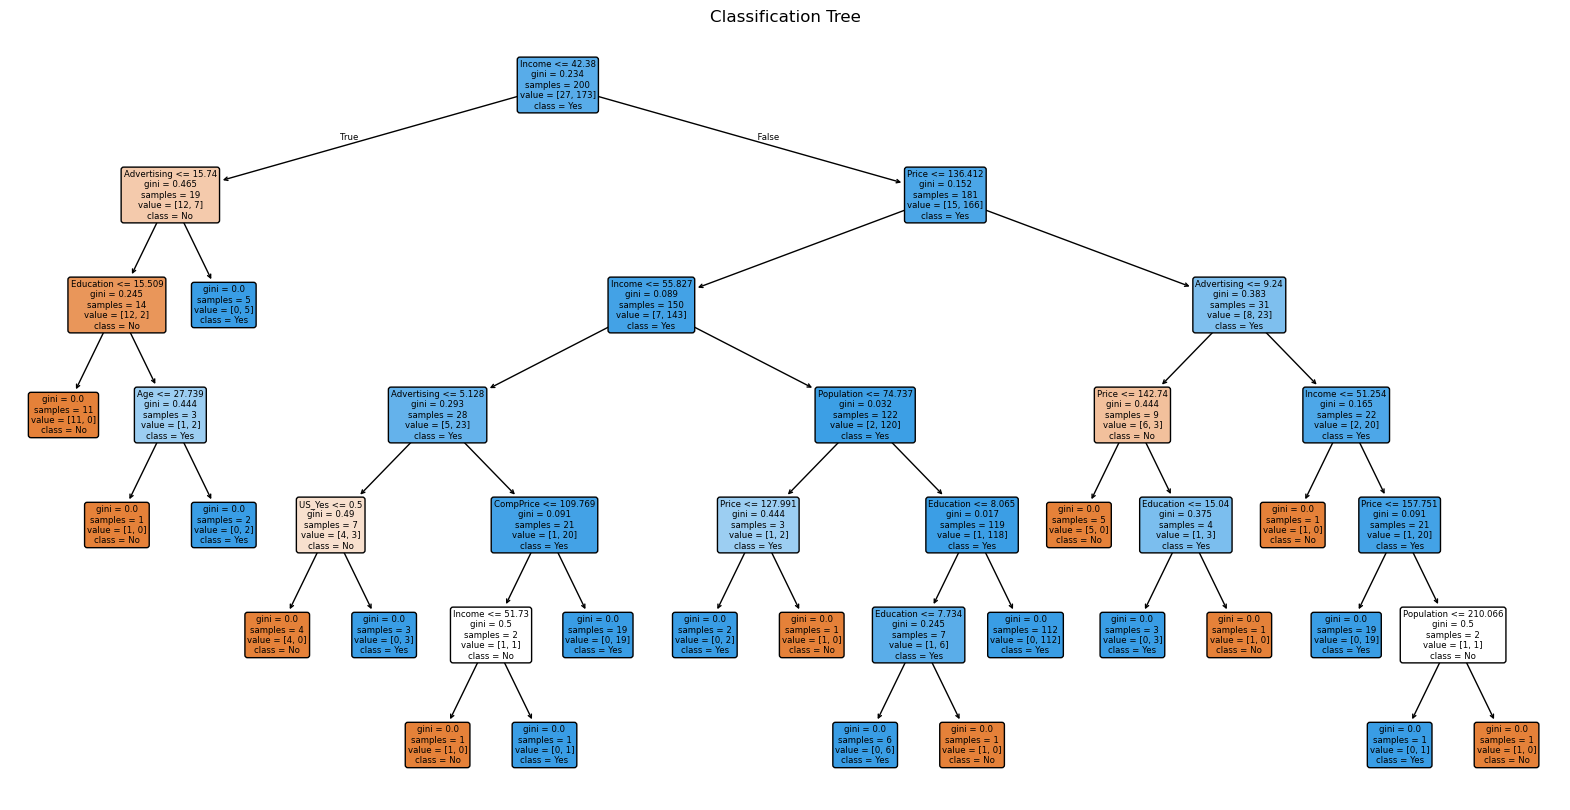

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title('Classification Tree')
plt.savefig('tree_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Predict and evaluate
y_pred = tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {np.mean(y_pred == y_test):.4f}")

Confusion Matrix:
[[ 16  21]
 [ 25 138]]
Accuracy: 0.7700


In [14]:
# Cross-validation for pruning (finding optimal tree complexity)
max_depth_values = range(1, 20)
cv_scores = []

In [15]:
for depth in max_depth_values:
    tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=2)
    scores = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(np.mean(scores))

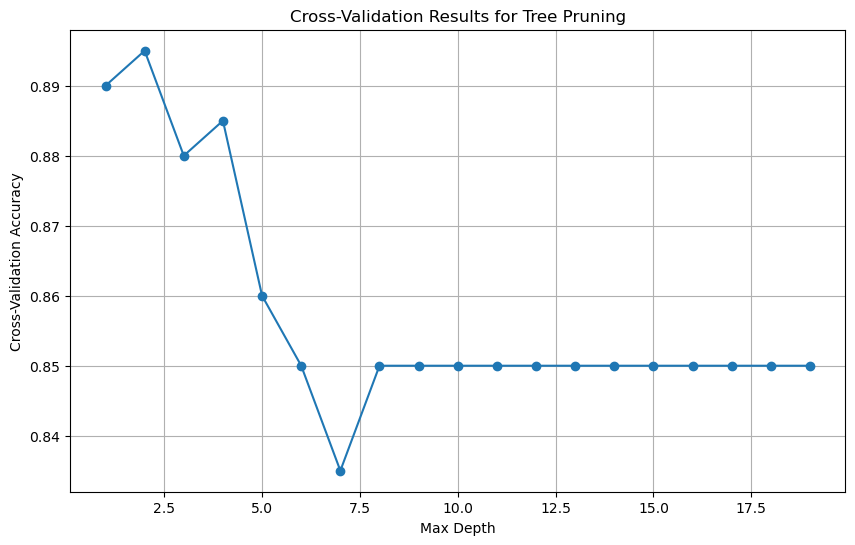

In [16]:
# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, 'o-')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Results for Tree Pruning')
plt.grid(True)
plt.show()

In [17]:
# Prune the tree (select best max_depth)
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best depth from cross-validation: {best_depth}")

Best depth from cross-validation: 2


In [18]:
pruned_tree = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, random_state=2)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=2)

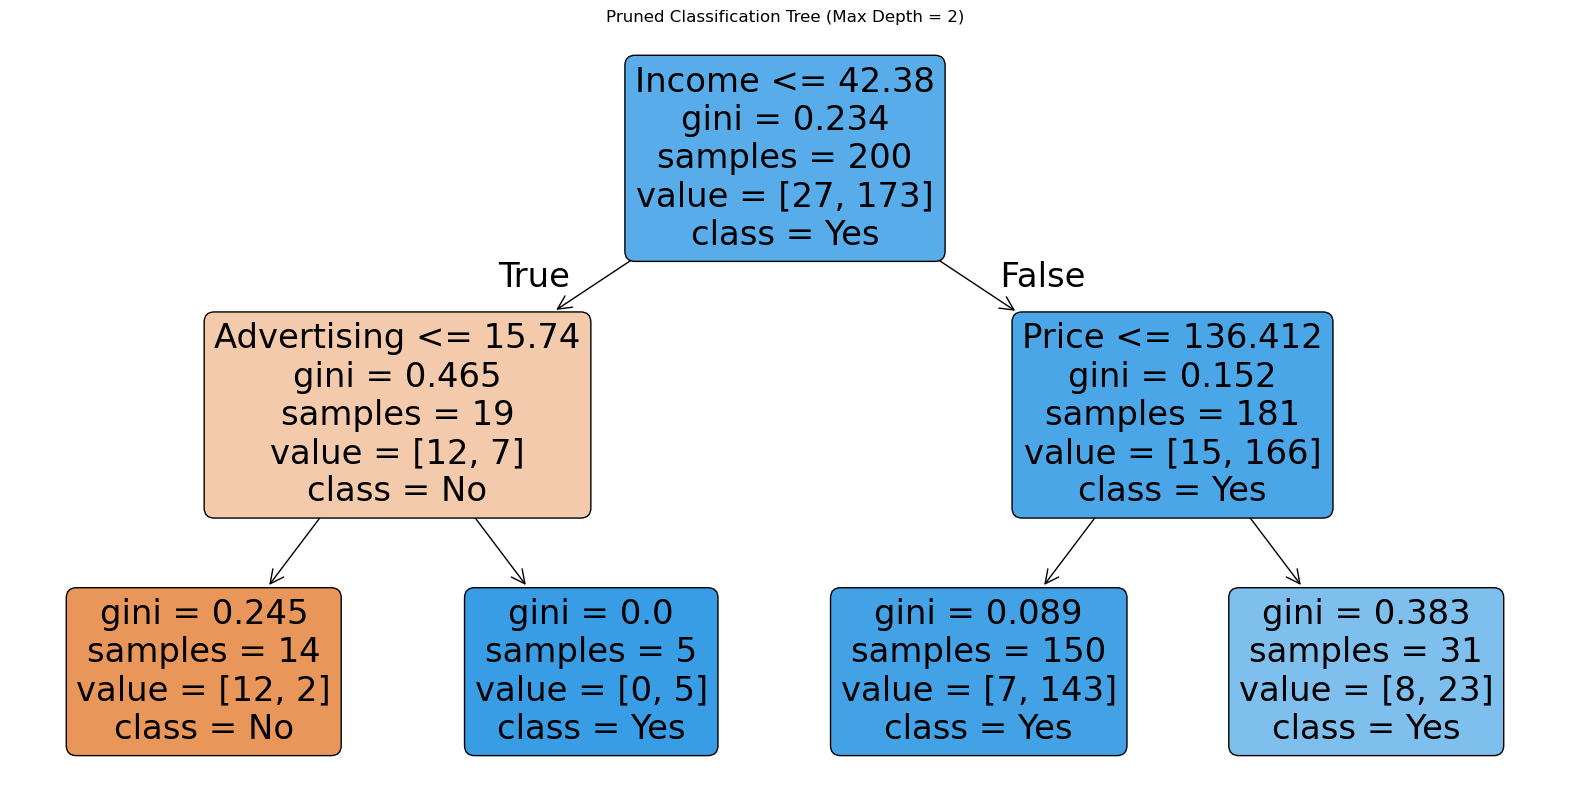

In [19]:
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title(f'Pruned Classification Tree (Max Depth = {best_depth})')
plt.savefig('pruned_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Evaluate pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
conf_matrix_pruned = confusion_matrix(y_test, y_pred_pruned)
print("Confusion Matrix (Pruned Tree):")
print(conf_matrix_pruned)
print(f"Accuracy (Pruned Tree): {np.mean(y_pred_pruned == y_test):.4f}")

Confusion Matrix (Pruned Tree):
[[  7  30]
 [ 13 150]]
Accuracy (Pruned Tree): 0.7850


# -------------------- Bagging and Random Forest ----------------

In [20]:
from ISLP import load_data
import pandas as pd
Boston = load_data('Boston')
boston_df = pd.DataFrame(Boston)

In [21]:
# Split into training and testing
np.random.seed(1)
X_boston = boston_df.drop('medv', axis=1)
y_boston = boston_df['medv']
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(
    X_boston, y_boston, test_size=0.5, random_state=1)

In [22]:
# Bagging (Random Forest with max features = total features)
bagg_model = RandomForestRegressor(
    n_estimators=500, 
    max_features=X_boston.shape[1],  # Use all features (equivalent to bagging)
    random_state=1,
    bootstrap=True  # Use bootstrap samples
)
bagg_model.fit(X_train_boston, y_train_boston)

RandomForestRegressor(max_features=12, n_estimators=500, random_state=1)

c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Us

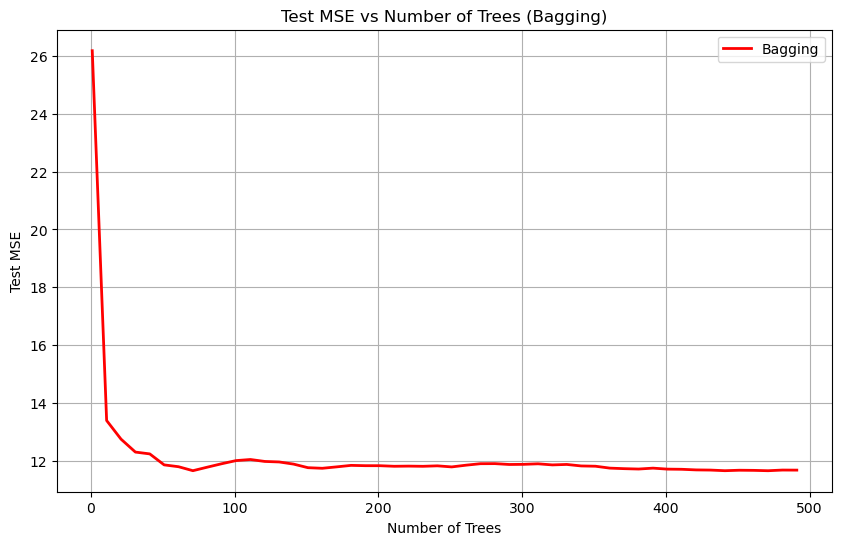

In [23]:
# Plot error vs number of trees
error_rate = []
for i in range(1, 501, 10):
    y_pred_bagg = np.mean([t.predict(X_test_boston) for t in bagg_model.estimators_[:i]], axis=0)
    error_rate.append(mean_squared_error(y_test_boston, y_pred_bagg))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 501, 10), error_rate, 'r-', lw=2, label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees (Bagging)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Predictions and evaluation
y_pred_bagg = bagg_model.predict(X_test_boston)
mse_bagg = mean_squared_error(y_test_boston, y_pred_bagg)
print(f"Bagging MSE: {mse_bagg:.4f}")

Bagging MSE: 11.6880


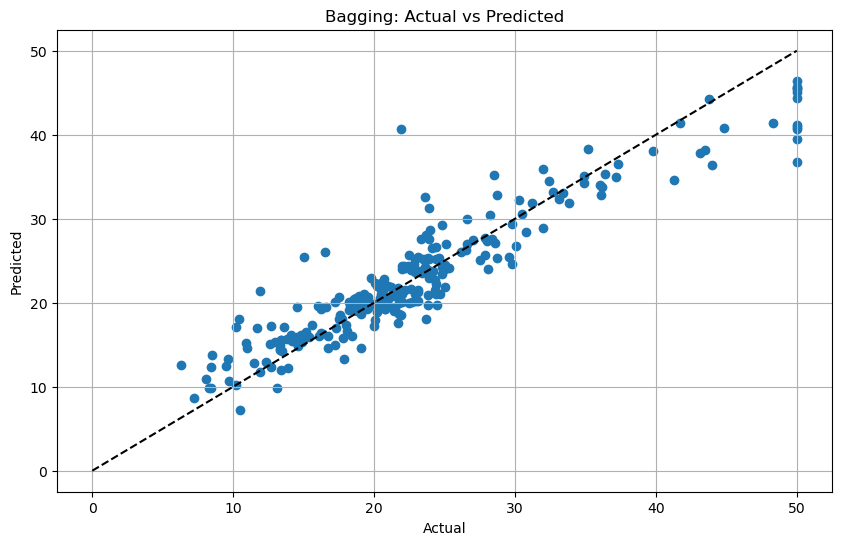

In [25]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_boston, y_pred_bagg)
plt.plot([0, 50], [0, 50], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bagging: Actual vs Predicted')
plt.grid(True)
plt.show()

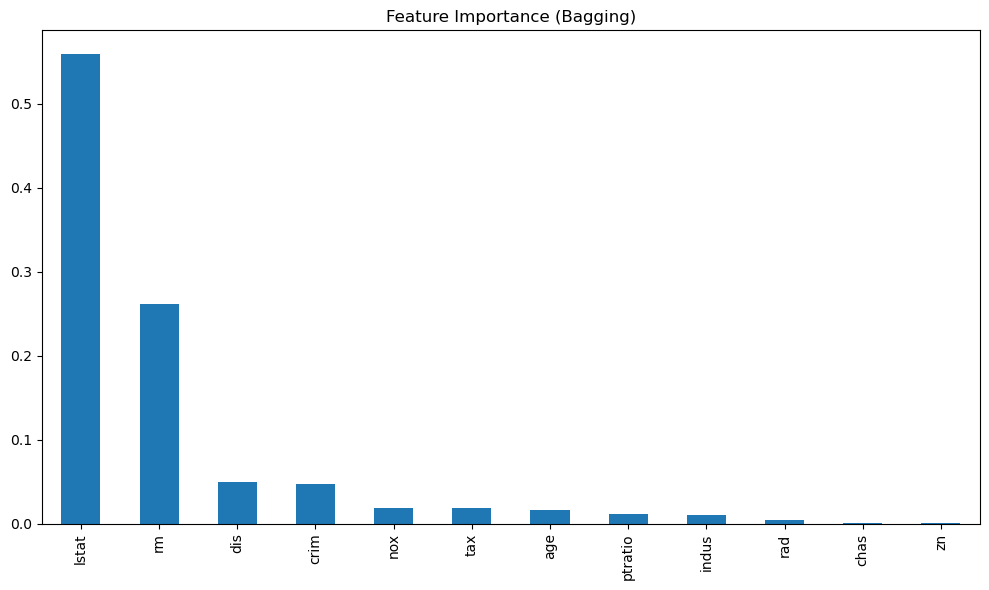

In [26]:
# Feature importance for bagging
importance_bagg = pd.Series(bagg_model.feature_importances_, index=X_boston.columns)
importance_bagg.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_bagg.plot(kind='bar')
plt.title('Feature Importance (Bagging)')
plt.tight_layout()
plt.show()

In [27]:
# Random Forest (uses sqrt of number of features by default)
forest_model = RandomForestRegressor(
    n_estimators=100, 
    max_features='sqrt',  # Default for RandomForest
    random_state=1
)
forest_model.fit(X_train_boston, y_train_boston)

RandomForestRegressor(max_features='sqrt', random_state=1)

In [28]:
# Error vs number of trees for Random Forest
error_rate_rf = []
for i in range(1, 101, 2):
    y_pred_rf = np.mean([t.predict(X_test_boston) for t in forest_model.estimators_[:i]], axis=0)
    error_rate_rf.append(mean_squared_error(y_test_boston, y_pred_rf))

c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\franc\anaconda3\envs\ml-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Us

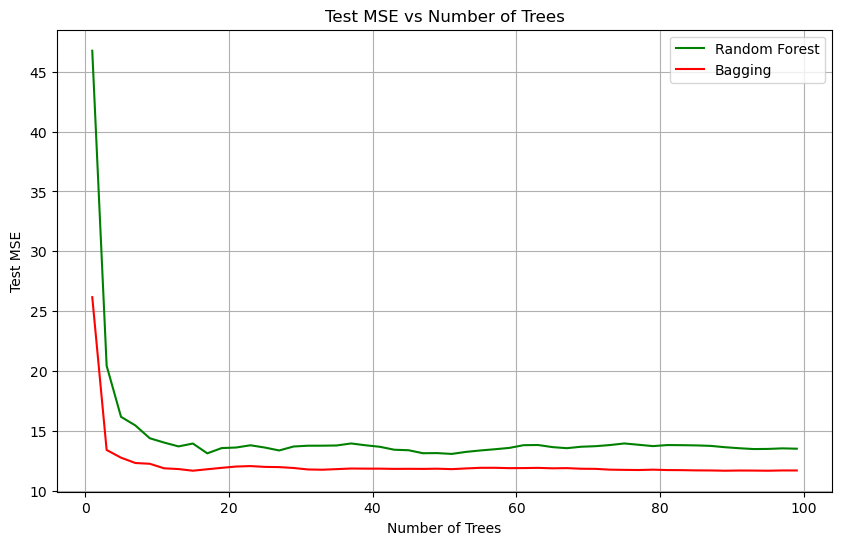

In [29]:
# Plot both bagging and random forest error rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101, 2), error_rate_rf[:50], 'g-', label='Random Forest')
plt.plot(range(1, 101, 2), error_rate[:50], 'r-', label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

Random Forest MSE: 13.6584


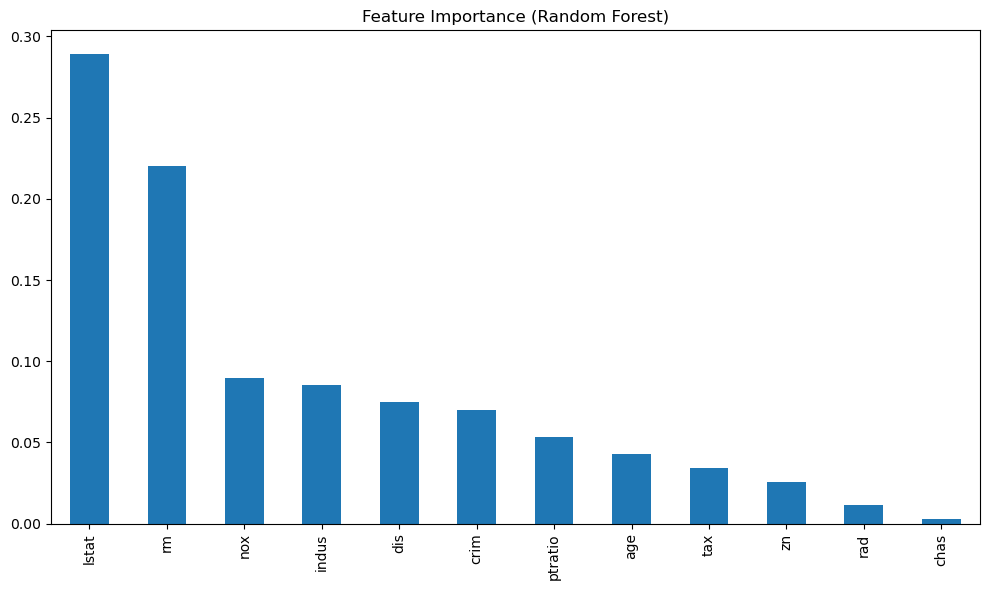

In [34]:
# Evaluation of Random Forest
y_pred_rf = forest_model.predict(X_test_boston)
mse_rf = mean_squared_error(y_test_boston, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.4f}")

# Feature importance for Random Forest
importance_rf = pd.Series(forest_model.feature_importances_, index=X_boston.columns)
importance_rf.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_rf.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# -------------------- Boosting --------------------

In [35]:
# Gradient Boosting
boost_model = GradientBoostingRegressor(
    n_estimators=5000,
    max_depth=4,
    learning_rate=0.01,
    loss='squared_error',  # equivalent to 'gaussian' in R's gbm
    random_state=1
)
boost_model.fit(X_train_boston, y_train_boston)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=5000,
                          random_state=1)

In [36]:
# Predictions and evaluation
y_pred_boost = boost_model.predict(X_test_boston)
mse_boost = mean_squared_error(y_test_boston, y_pred_boost)
print(f"Boosting MSE: {mse_boost:.4f}")

# Compare all methods
methods = ['Bagging', 'Random Forest', 'Boosting']
mse_values = [mse_bagg, mse_rf, mse_boost]

Boosting MSE: 10.5702


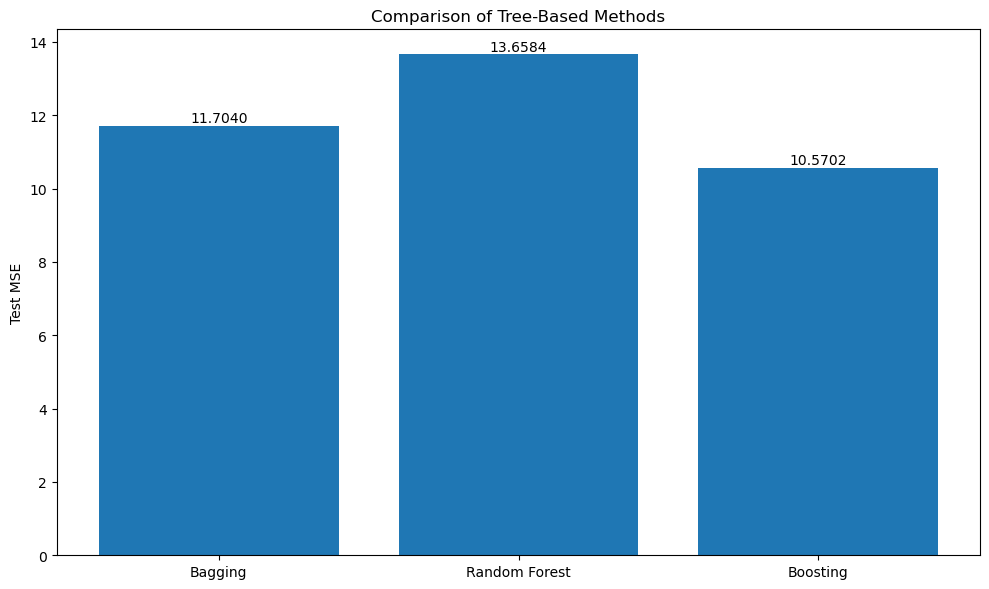

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values)
plt.ylabel('Test MSE')
plt.title('Comparison of Tree-Based Methods')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.1, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()